In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
from matplotlib.gridspec import GridSpec
import time
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.covariance import EmpiricalCovariance
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from collections import defaultdict
from lightgbm import LGBMClassifier
from mpl_toolkits.mplot3d import Axes3D
from glob import glob
import seaborn as sns
from scipy import stats, signal
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import interact, fixed

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 1. 预处理

In [2]:
files = glob("../datas/NPI数据收集/LG-1/TCM data/*.csv")
df = pd.concat([pd.read_csv(file, encoding='utf8', on_bad_lines='skip') for file in files], ignore_index=True)
# df.to_csv("../datas/NPI数据收集/LG-1/tcmdata.csv", index=False)

In [3]:
df['filename'] = df['filename'].replace(r'_pos\d+', '', regex=True)
df = df.sort_values(['DateTime', 'filename'])  #
df

,DateTime,Pass/Fail,filename,SN,screw position,screw number,failure_clamp,failure_slip,failure_rehit,failure_angle,...,ErrorCode,Algorithm,setting_seat_location_thresh,setting_extrema_thresh,setting_extrema_lookback,setting_torque_thresh_start,config_file_name,rel_extrema_delta,rel_max_avg,rel_min_avg
3,2025/05/05 13:34,Pass,F9W004567750000X7T_ScrewNum1_2025050513340205_...,F9W004567750000X7T,4,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,4.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc4_Half_Config_V3,0.007,0.322,0.315
1,2025/05/05 13:34,Pass,F9W004567750000X7T_ScrewNum1_2025050513341226_...,F9W004567750000X7T,2,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,4.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc2_Config_V3,0,0,0
0,2025/05/05 13:34,Pass,F9W004567750000X7T_ScrewNum1_2025050513342210_...,F9W004567750000X7T,1,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,4.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc1_Config_V3,0.005,0.129,0.124
2,2025/05/05 13:34,Pass,F9W004567750000X7T_ScrewNum1_2025050513342428_...,F9W004567750000X7T,41,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,0.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc41_Full_Config_V4,Not_Analyzed,Not_Analyzed,Not_Analyzed
7,2025/05/05 13:35,Pass,F9W004733580000X7T_ScrewNum1_2025050513350547_...,F9W004733580000X7T,4,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,4.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc4_Half_Config_V3,0.024,0.341,0.317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,2025/07/31 19:55,Pass,HVWHK0000090000XQ7_ScrewNum1_2025073119550043_...,HVWHK0000090000XQ7,41,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,0.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc41_Full_Config_V4,Not_Analyzed,Not_Analyzed,Not_Analyzed
29676,2025/07/31 20:01,Pass,HVWHK00000F0000XQ7_ScrewNum1_2025073120002979_...,HVWHK00000F0000XQ7,4,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,4.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc4_Half_Config_V3,0.022,0.196,0.175
29674,2025/07/31 20:01,Pass,HVWHK00000F0000XQ7_ScrewNum1_2025073120004005_...,HVWHK00000F0000XQ7,2,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,4.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc2_Config_V3,0.052,0.247,0.195
29673,2025/07/31 20:01,Pass,HVWHK00000F0000XQ7_ScrewNum1_2025073120005027_...,HVWHK00000F0000XQ7,1,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,4.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc1_Config_V3,0.024,0.122,0.098


In [4]:
fail_cols = [x for x in df.columns if 'failure_' in x or '_result' in x]

for col in fail_cols:
    if df[col].value_counts().to_dict().get('Fail', 0) > 20:
        print(f"{col}: {df[col].value_counts().to_dict()}")

failure_clamp: {'Pass': 29189, 'Fail': 488}
failure_rehit: {'Pass': 29636, 'Fail': 41}
failure_angle: {'Pass': 29635, 'Fail': 42}
failure_excess_friction: {'Pass': 29583, 'Fail': 94}
failure_clampangle_spec: {'Pass': 29176, 'Fail': 501}
clamp_torque_result: {'Pass': 29189, 'Fail': 488}
clamp_angle_max_result: {'Pass': 29176, 'Fail': 501}
clamp_angle_min_result: {'Pass': 29189, 'Fail': 488}


# 2. 分析

## 2.1 异常检测

In [17]:
df[df['angle_max'] < 0]

,DateTime,Pass/Fail,filename,SN,screw position,screw number,failure_clamp,failure_slip,failure_rehit,failure_angle,...,ErrorCode,Algorithm,setting_seat_location_thresh,setting_extrema_thresh,setting_extrema_lookback,setting_torque_thresh_start,config_file_name,rel_extrema_delta,rel_max_avg,rel_min_avg
2,2025/05/05 13:34,Pass,F9W004567750000X7T_ScrewNum1_2025050513342428_...,F9W004567750000X7T,41,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,0.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc41_Full_Config_V4,Not_Analyzed,Not_Analyzed,Not_Analyzed
6,2025/05/05 13:35,Pass,F9W004733580000X7T_ScrewNum1_2025050513354382_...,F9W004733580000X7T,41,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,0.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc41_Full_Config_V4,Not_Analyzed,Not_Analyzed,Not_Analyzed
21,2025/05/06 08:44,Pass,F9W004620130000X7T_ScrewNum1_2025050608435579_...,F9W004620130000X7T,41,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,0.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc41_Full_Config_V4,Not_Analyzed,Not_Analyzed,Not_Analyzed
29,2025/05/06 11:21,Pass,F9WHG3000160000X7T_ScrewNum1_2025050611205947_...,F9WHG3000160000X7T,41,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,0.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc41_Full_Config_V4,Not_Analyzed,Not_Analyzed,Not_Analyzed
33,2025/05/06 11:22,Pass,F9WHG30001W0000X7T_ScrewNum1_2025050611221328_...,F9WHG30001W0000X7T,41,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,0.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc41_Full_Config_V4,Not_Analyzed,Not_Analyzed,Not_Analyzed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29641,2025/07/31 14:33,Pass,F9WHJ5000JK0000X7S_ScrewNum1_2025073114330415_...,F9WHJ5000JK0000X7S,41,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,0.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc41_Full_Config_V4,Not_Analyzed,Not_Analyzed,Not_Analyzed
29648,2025/07/31 14:35,Pass,F9WHHS000AS0000X7S_ScrewNum1_2025073114351295_...,F9WHHS000AS0000X7S,41,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,0.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc41_Full_Config_V4,Not_Analyzed,Not_Analyzed,Not_Analyzed
29659,2025/07/31 19:44,Pass,HVWHK00000C0000XQ7_ScrewNum1_2025073119443160_...,HVWHK00000C0000XQ7,41,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,0.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc41_Full_Config_V4,Not_Analyzed,Not_Analyzed,Not_Analyzed
29663,2025/07/31 19:47,Pass,HVWHK0000080000XQ7_ScrewNum1_2025073119472841_...,HVWHK0000080000XQ7,41,1,Pass,Pass,Pass,Pass,...,NaN,Apple_TCM_Pro_v5s5.exe,0.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc41_Full_Config_V4,Not_Analyzed,Not_Analyzed,Not_Analyzed


In [ ]:
df_use = df.copy()
df_use.replace("Not_Analyzed", None, inplace=True)

features = [
    'angle_start', 'angle_max', 'torque_start', 'torque_max', 'torque_final',
    'clamp_torque', 'clamp_angle', 'torque_sit', 'angle_sit',
    'max_torque_before_sit', 'angle_at_maxTorque_before_sit',
    'angular_work_total', 'angular_work_after_sit',
    'angular_work_before_sit', 'clamp_torque_percentage',
    'torque_sit_percentage', 'Normalized_integral', 'gradient_mean',
    'gradient_stdev', 'max derivative', 'max double derivative',
    'gradient_negative_mean', 'gradient_negative_stdev', 'skew_total',
    'skew_negative', 'kurtosis_total', 'kurtosis_negative', 'FFT_Max',
    'FFT_Freq_360', 'FFT_Average', 'FFT_Median', 'FFT_StDev',
    'LSRL_int', 'LSRL_r^2', 'LSRL_slope_norm',
    'LSRL_int_norm', 'LSRL_r^2_norm'
]
for col in features:
    df_use[col] = df_use[col].astype(float)


In [86]:
class ScrewdriverReplacementAnalyzer:
    def __init__(self, window_size=20, failure_threshold=3, 
                 screw_positions=[1, 2, 4, 41], top_causes=3):
        """
        初始化螺丝刀更换分析器
        
        参数:
        - window_size: 滑动窗口大小
        - failure_threshold: 连续异常次数阈值
        - screw_positions: 螺丝位置顺序列表（按拧紧顺序）
        - top_causes: 输出前N个主要原因
        """
        self.window_size = window_size
        self.failure_threshold = failure_threshold
        self.screw_positions = screw_positions
        self.top_causes = top_causes
        # 特征权重（根据工程经验调整）
        self.feature_weights = {
            'torque_max': 1.0,          # 最高权重：最大扭矩直接反映拧紧力度
            'clamp_torque': 0.9,         # 夹紧扭矩不足是主要失效模式
            'angle_max': 0.85,           # 角度超差影响装配精度
            'clamp_angle': 0.8,         # 
            'Normalized_integral': 0.8,  # 能量积分反映整体拧紧质量
            'gradient_mean': 0.7,        # 扭矩变化率异常预示摩擦增大
            'FFT_Max': 0.6               # 高频振动异常
        }
        
        # 位置权重（根据拧紧顺序重要性调整）
        self.position_weights = {pos: 1.0/len(screw_positions) for pos in screw_positions}
        
        # 存储中间结果
        self.position_dfs = {}
        self.combined_df = None
        self.cause_records = []

    def _preprocess_position_data(self, pos_df, pos):
        """预处理单个螺丝位置数据"""
        # 关键特征列表（按重要性排序）
        features = list(self.feature_weights.keys())
        existing_features = [f for f in features if f in pos_df.columns]
        
        # 缺失值处理（后向填充+中位数填充）
        pos_df = pos_df.copy()
        pos_df[existing_features] = pos_df[existing_features].bfill().ffill()
        for f in existing_features:
            if pos_df[f].isna().any():
                pos_df[f] = pos_df[f].fillna(pos_df[f].median())
        
        # 滑动窗口标准化（时间序列感知）
        for f in existing_features:
            pos_df[f'{f}_rolling'] = pos_df[f].rolling(window=self.window_size, min_periods=1).mean()
            pos_df[f'{f}_std'] = pos_df[f].rolling(window=self.window_size, min_periods=1).std()
            # 标准化当前值（相对于窗口均值）
            pos_df[f'{f}_zscore'] = (pos_df[f] - pos_df[f'{f}_rolling']) / (pos_df[f'{f}_std'] + 1e-8)  # 防止除零

        # 计算直接失败标志
        pos_df['direct_failure'] = ((pos_df['failure_clamp'] == 'Fail') | (pos_df['failure_clampangle_spec'] == 'Fail')).astype(int)
        # 记录位置信息
        pos_df['screw_position'] = pos
        
        return pos_df, existing_features

    def _calculate_feature_contributions(self, pos_df):
        """计算各特征对异常的贡献度"""
        # 异常检测分数（Isolation Forest）
        clf = IsolationForest(contamination=0.05, random_state=42)
        X = pos_df[[f'{f}_zscore' for f in self.feature_weights.keys()]].fillna(0)
        pos_df['anomaly_score'] = clf.fit_predict(X)
        pos_df['anomaly_score'] = (pos_df['anomaly_score'] == -1).astype(int) * 2  # 转换为0/2分数
        
        # 特征贡献度计算（基于z-score偏离程度）
        contribution = defaultdict(float)
        for f in self.feature_weights.keys():
            z_col = f'{f}_zscore'
            if z_col in pos_df.columns:
                # 异常时贡献度=权重*|z-score|，正常时贡献度=0
                contribution[f] = self.feature_weights[f] * pos_df[z_col].fillna(0).abs()
        
        # 归一化总贡献度
        total_contribution = pos_df[list(contribution.keys())].sum(axis=1) + 1e-8
        for f in contribution:
            contribution[f] = contribution[f] / total_contribution
        
        # 记录直接失败贡献
        contribution['direct_failure'] = pos_df['direct_failure'] * 0.5  # 固定权重
        
        return pos_df, contribution

    def analyze_position(self, pos_df, pos):
        """分析单个螺丝位置数据"""
        start_time = time.time()
        
        # 预处理
        pos_df, existing_features = self._preprocess_position_data(pos_df, pos)
        self.position_dfs[pos] = pos_df
        
        # 计算特征贡献
        pos_df, contribution = self._calculate_feature_contributions(pos_df)
        
        # 检测连续异常
        pos_df['failure_count'] = pos_df['anomaly_score'].rolling(window=self.window_size, min_periods=1).sum()
        pos_df['need_replacement'] = (pos_df['failure_count'] >= self.failure_threshold).astype(int)
        
        # 记录更换原因（仅当需要更换时）
        replacement_mask = pos_df['need_replacement'] == 1
        if replacement_mask.any():
            for idx in pos_df.index[replacement_mask]:
                # 获取前N大贡献特征
                top_features = sorted(contribution.items(), key=lambda x: x[1][idx], reverse=True)[:self.top_causes]
                
                # 构造原因记录
                cause = {
                    'time': pos_df.loc[idx, 'DateTime'],
                    'filename': pos_df.loc[idx, 'filename'],  # 新增：文件名
                    'screw_position': pos,
                    'sn': pos_df.loc[idx, 'SN'],
                    'screw_number': pos_df.loc[idx, 'screw number'],
                    'main_cause': top_features[0][0],
                    'top_causes': [(f[0], round(f[1][idx], 4)) for f in top_features],
                    'anomaly_score': pos_df.loc[idx, 'anomaly_score'],
                    'failure_count': pos_df.loc[idx, 'failure_count']
                }
                self.cause_records.append(cause)
        
        print(f"Processed position {pos} in {time.time()-start_time:.2f}s")
        return pos_df

    def analyze_all_positions(self, df):
        """分析所有螺丝位置数据"""
        # 按位置分组处理
        for pos in self.screw_positions:
            pos_df = df[df['screw position'] == pos].copy()
            if not pos_df.empty:
                self.analyze_position(pos_df, pos)
        
        # 合并所有位置数据（按时间排序）
        self.combined_df = pd.concat([
            self.position_dfs[pos][['DateTime', 'filename', 'SN', 'screw position', 'screw number',
                                    'torque_max', 'clamp_torque', 'angle_max',
                                    'anomaly_score', 'failure_count', 'need_replacement']]
            for pos in self.screw_positions
        ]).sort_values(['DateTime', 'filename']).reset_index(drop=True)
        
        return self.combined_df

    def plot_key_metrics(self, save_path=None):
        """绘制关键指标趋势图（加速版）"""
        if self.combined_df is None:
            raise ValueError("No analysis results available. Run analyze_all_positions first.")
        
        # 数据降采样（每100个点取1个，可根据数据量调整）
        sample_df = self.combined_df if len(self.combined_df) <= 1000 else self.combined_df[::100]
        
        # 创建画布
        fig, axes = plt.subplots(3, 1, figsize=(24, 12), sharex=True)
        fig.suptitle('Screwdriver Replacement Analysis Key Metrics', fontsize=14)
        
        # 绘制扭矩相关指标
        ax1 = axes[0]
        for pos in self.screw_positions:
            pos_data = sample_df[sample_df['screw position'] == pos]
            ax1.plot(pos_data['DateTime'], pos_data['torque_max'], label=f'Pos {pos} Torque Max', linewidth=1.5)
            # 标记更换信号
            replace_mask = pos_data['need_replacement'] == 1
            ax1.scatter(pos_data.loc[replace_mask, 'DateTime'], 
                       pos_data.loc[replace_mask, 'torque_max'], 
                       color='red', s=50, marker='*', label='Replace Signal')
        ax1.set_ylabel('Torque (N·m)')
        ax1.legend(bbox_to_anchor=(1.02, 1), loc='best')
        ax1.grid(alpha=0.3)
        
        # 绘制角度相关指标
        ax2 = axes[1]
        for pos in self.screw_positions:
            pos_data = sample_df[sample_df['screw position'] == pos]
            ax2.plot(pos_data['DateTime'], pos_data['angle_max'], 
                    label=f'Pos {pos} Angle Max', linewidth=1.5, color='orange')
        ax2.set_ylabel('Angle (deg)')
        ax2.legend(bbox_to_anchor=(1.02, 1), loc='best')
        ax2.grid(alpha=0.3)
        
        # 绘制异常分数
        ax3 = axes[2]
        for pos in self.screw_positions:
            pos_data = sample_df[sample_df['screw position'] == pos]
            ax3.plot(pos_data['DateTime'], pos_data['anomaly_score'], 
                    label=f'Pos {pos} Anomaly Score', linewidth=1.5, color='green')
            ax3.axhline(y=1, color='gray', linestyle='--', alpha=0.5)  # 异常阈值
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Anomaly Score')
        ax3.legend(bbox_to_anchor=(1.02, 1), loc='best')
        ax3.grid(alpha=0.3)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        # 保存或显示
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {save_path}")
        else:
            plt.show()

    def get_causes_by_filename(self, target_filename):
        """根据文件名筛选异常原因并生成无换行报告"""
        if not self.cause_records:
            return f"📘 文件 {target_filename} 无异常记录。"
        
        # 筛选指定文件的所有异常原因记录
        file_causes = [cause for cause in self.cause_records 
                    if cause['filename'] == target_filename]
        
        if not file_causes:
            return f"📘 文件 {target_filename} 无异常记录。"
        
        # 按时间排序（与合并数据逻辑一致）
        sorted_causes = sorted(file_causes, key=lambda x: (x['time'], x['screw_position']))
        
        # 获取该文件的所有原始数据（用于提取异常点的具体数值）
        file_data = self.combined_df[self.combined_df['filename'] == target_filename]
        
        # 初始化报告列表（无换行）
        report_parts = []
        
        # 添加文件头
        report_parts.append(f"📘 文件异常分析报告：{target_filename} ────────────────────────────────────────────────────────────")
        
        for i, cause in enumerate(sorted_causes, 1):
            # 获取异常点在原始数据中的行（取第一个匹配项）
            data_row = file_data[file_data['DateTime'] == cause['time']].iloc[0]
            
            # 提取关键指标数值（格式化为一行）
            metrics = (
                f"📊 关键指标（异常时）| "
                f"最大扭矩(torque_max):{data_row['torque_max']:.2f}| "
                f"夹紧扭矩(clamp_torque):{data_row['clamp_torque']:.2f}| "
                f"最大角度(angle_max):{data_row['angle_max']:.2f}"
            )
            
            # 提取主要异常原因（格式化为一行）
            causes_str = "|".join([
                f"{j+1}.{feature}({score*100:.1f}%)" 
                for j, (feature, score) in enumerate(cause['top_causes'], 1)
            ])
            main_causes = f"❗ 主要异常原因| {causes_str}"
            
            # 组合异常事件信息（单行）
            event = (
                f"🔍 异常事件 {i}: "
                f"⏰ 时间:{cause['time']} | "
                f"📍 螺丝位置:{cause['screw_position']} | "
                f"🔧 设备信息:SN={cause['sn']},螺丝编号={cause['screw_number']} | "
                f"{metrics} | "
                f"{main_causes} | "
                f"📈 异常分数:{cause['anomaly_score']}(连续异常次数:{cause['failure_count']})"
            )
            
            # 添加分隔线和事件信息
            report_parts.extend([
                "───────────────────────────────────────────────────────────",
                event
            ])
        
        # 合并所有部分（无换行，用空格连接）
        return "".join(report_parts)

In [88]:
# 初始化分析器
analyzer = ScrewdriverReplacementAnalyzer(
    window_size=50,
    failure_threshold=3,
    screw_positions=[4,1,2,41],
    top_causes=3
)

# 执行分析
print("Starting analysis...")
combined_df = analyzer.analyze_all_positions(df_use)

Starting analysis...
Processed position 4 in 0.52s
Processed position 1 in 0.44s
Processed position 2 in 0.58s
Processed position 41 in 0.41s


In [89]:
analyzer.get_causes_by_filename('F9WHG80000B0000X7U_ScrewNum1_2025050615271705_LA6_SPK_CHG_TO_HSG_Loc2_Config_V3.csv')

'📘 文件异常分析报告：F9WHG80000B0000X7U_ScrewNum1_2025050615271705_LA6_SPK_CHG_TO_HSG_Loc2_Config_V3.csv ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────🔍 异常事件 1: ⏰ 时间:2025/05/06 15:27 | 📍 螺丝位置:2 | 🔧 设备信息:SN=F9WHG80000B0000X7U,螺丝编号=1 | 📊 关键指标（异常时）| 最大扭矩(torque_max):0.34| 夹紧扭矩(clamp_torque):0.19| 最大角度(angle_max):1159.92 | ❗ 主要异常原因| 2.clamp_torque(0.1%)|3.Normalized_integral(0.1%)|4.torque_max(0.1%) | 📈 异常分数:2(连续异常次数:4.0)'

In [57]:
combined_df

,DateTime,filename,SN,screw position,screw number,torque_max,clamp_torque,angle_max,anomaly_score,failure_count,need_replacement
0,2025/05/05 13:34,F9W004567750000X7T_ScrewNum1_2025050513340205_...,F9W004567750000X7T,4,1,0.172,0.104,959.04,0,0.0,0
1,2025/05/05 13:34,F9W004567750000X7T_ScrewNum1_2025050513341226_...,F9W004567750000X7T,2,1,0.343,0.193,1096.20,0,0.0,0
2,2025/05/05 13:34,F9W004567750000X7T_ScrewNum1_2025050513342210_...,F9W004567750000X7T,1,1,0.344,0.276,1143.18,0,0.0,0
3,2025/05/05 13:34,F9W004567750000X7T_ScrewNum1_2025050513342428_...,F9W004567750000X7T,41,1,0.344,0.019,-37.26,0,0.0,0
4,2025/05/05 13:35,F9W004733580000X7T_ScrewNum1_2025050513350547_...,F9W004733580000X7T,4,1,0.172,0.113,1016.28,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
29672,2025/07/31 19:55,HVWHK0000090000XQ7_ScrewNum1_2025073119550043_...,HVWHK0000090000XQ7,41,1,0.344,0.017,-10.26,0,6.0,1
29673,2025/07/31 20:01,HVWHK00000F0000XQ7_ScrewNum1_2025073120002979_...,HVWHK00000F0000XQ7,4,1,0.172,0.130,852.66,0,2.0,0
29674,2025/07/31 20:01,HVWHK00000F0000XQ7_ScrewNum1_2025073120004005_...,HVWHK00000F0000XQ7,2,1,0.340,0.207,881.28,0,2.0,0
29675,2025/07/31 20:01,HVWHK00000F0000XQ7_ScrewNum1_2025073120005027_...,HVWHK00000F0000XQ7,1,1,0.341,0.282,683.10,0,2.0,0


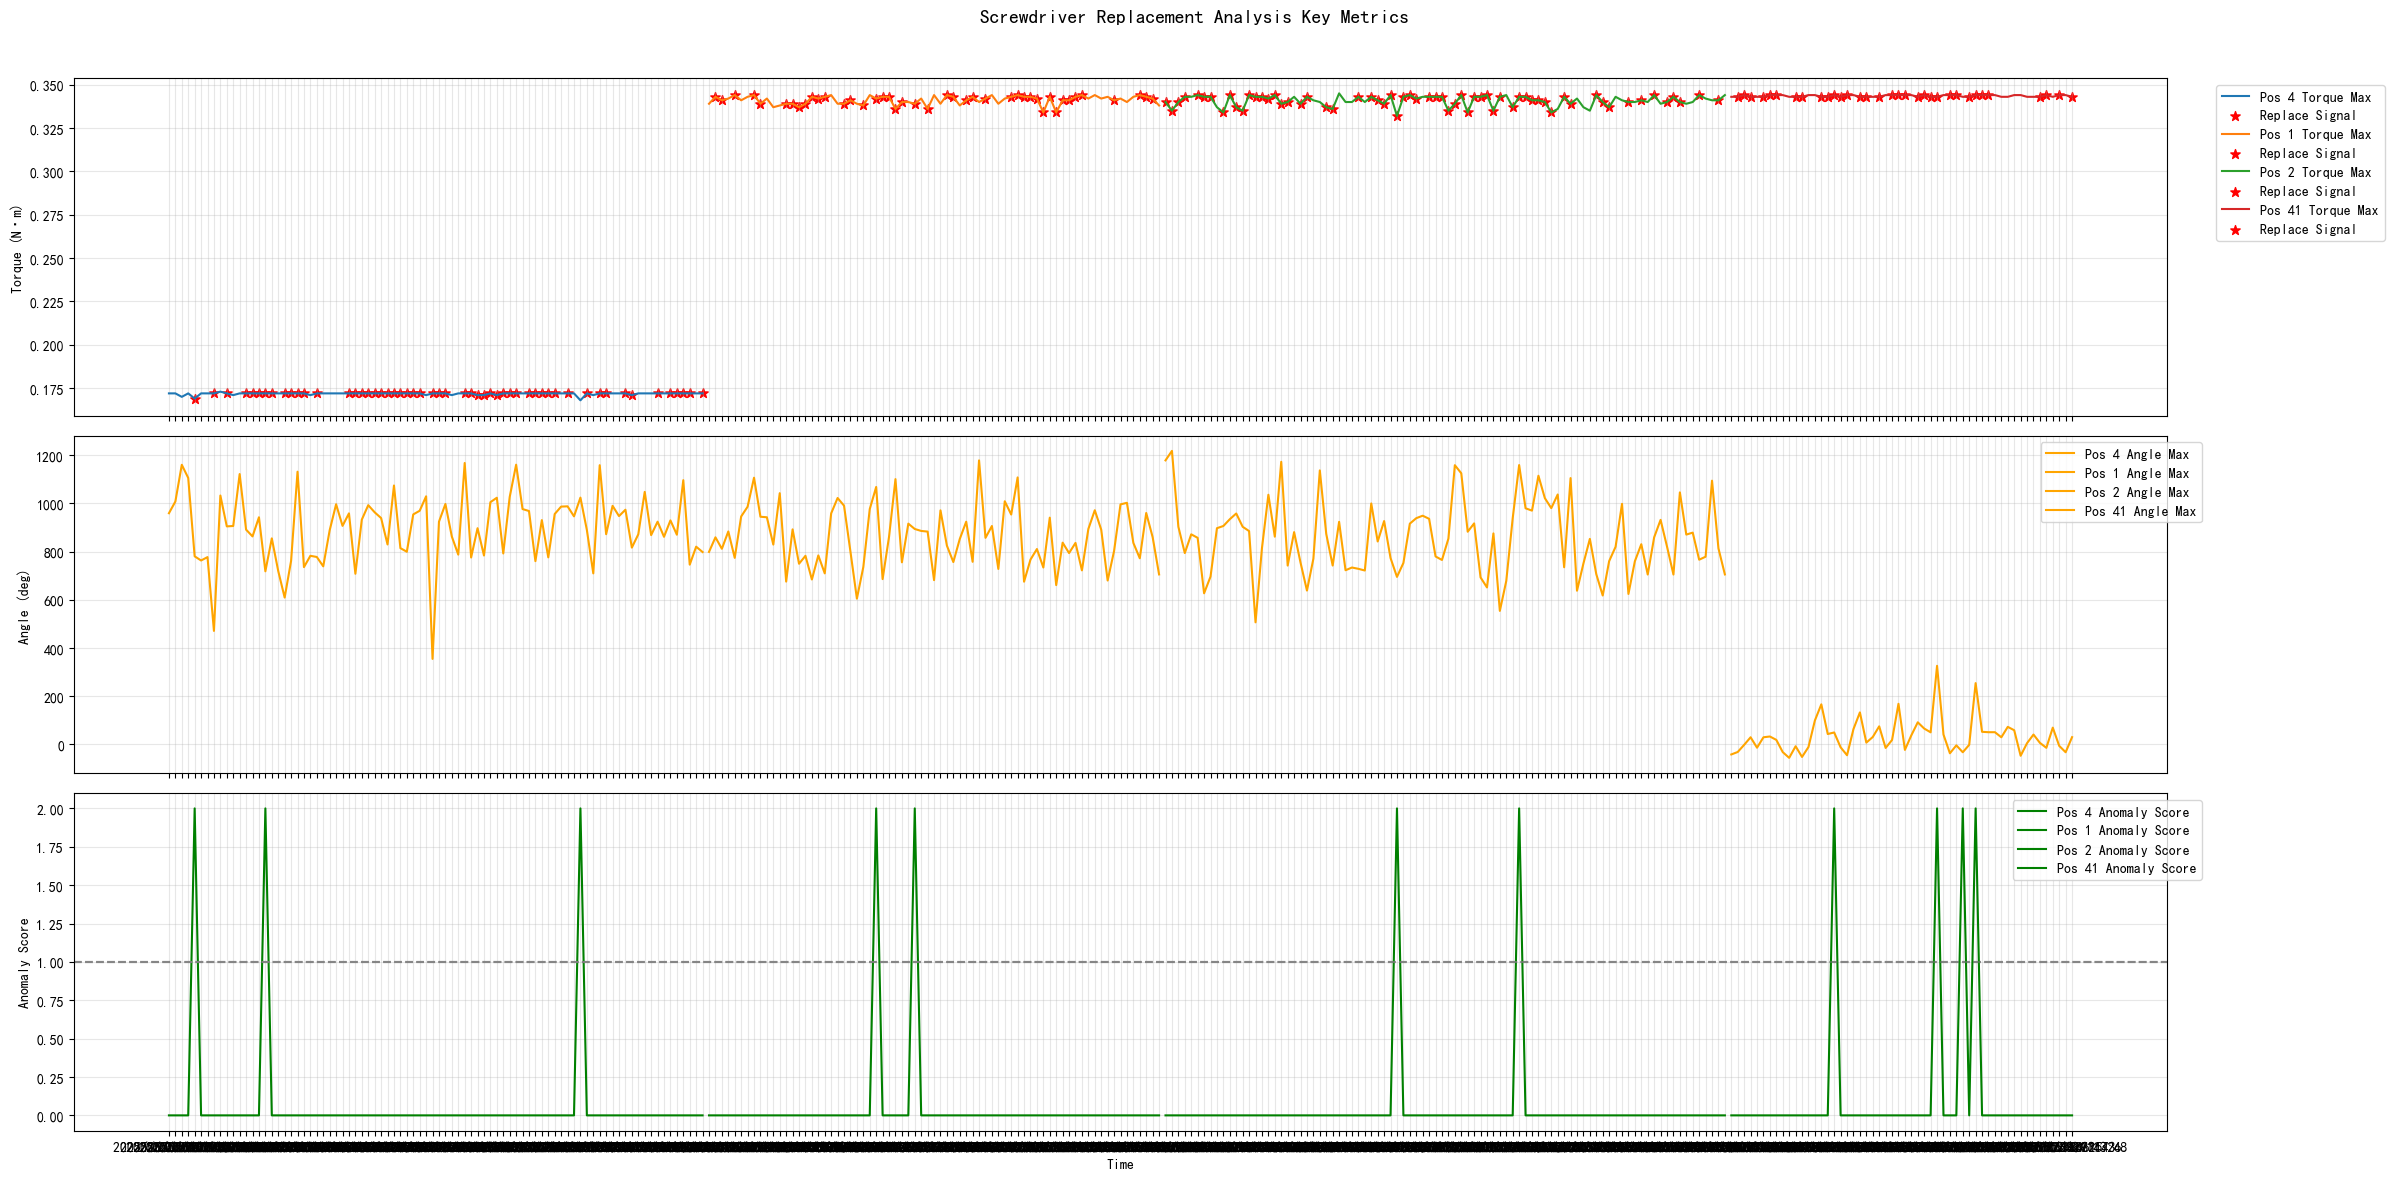

In [56]:
# 绘制关键指标图（保存到当前目录）save_path='screwdriver_analysis.png'
analyzer.plot_key_metrics()